In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import lightgbm as lgb
import imblearn
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sweetviz import FeatureConfig
from sklearn.model_selection import RandomizedSearchCV


file_path = 'GT_IPI.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')

/Users/hongdazhang/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# specifiy the columns for one-hot encoding
categorical_cols = ['begins_with', 'para_foll_depth_ind', 'para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind']
df_encoded = pd.get_dummies(df, columns=categorical_cols,prefix=categorical_cols)
df_encoded.head()

,css_pk,customer_pk,is_italic,is_bold,html_pk,id,is_underline,target,form_rel_depth,form_rel_font_size,...,para_foll_depth_ind_1,para_foll_size_ind_-1,para_foll_size_ind_0,para_foll_size_ind_1,para_prec_depth_ind_-1,para_prec_depth_ind_0,para_prec_depth_ind_1,para_prec_size_ind_-1,para_prec_size_ind_0,para_prec_size_ind_1
0,5625805,1855,0,0,5625806,423509|5625806|3941A609,0,question,82,1,...,False,False,True,False,False,False,True,False,True,False
1,5625805,1855,0,0,5625806,423509|5625806|1D86D710,0,discarded,82,1,...,False,False,True,False,False,True,False,False,True,False
2,5625805,1855,0,0,5625806,423509|5625806|51F7EBA6,0,discarded,83,1,...,False,False,True,False,False,False,True,False,True,False
3,5625805,1855,0,0,5625806,423509|5625806|268B6CF4,0,question,84,1,...,False,False,True,False,False,False,True,False,True,False
4,5625805,1855,0,0,5625806,423509|5625806|4BE54277,0,discarded,84,1,...,False,False,True,False,False,True,False,False,True,False


In [4]:
# One Hot Encoding for target for hierachical 
df_encoded_OHtarget=pd.get_dummies(df_encoded,columns=['target'], prefix=['target'])
df_encoded_OHtarget['target']=df['target']

In [5]:
df_encoded_OHtarget.shape

(5539963, 100)

In [6]:
# Load unique index
indices_df=pd.read_csv('unique_indexes.csv')
unique_index=indices_df['unique_index'].values

In [7]:
# Apply unique index to original data with dummies
df_filtered= df_encoded_OHtarget.loc[unique_index]

In [8]:
df_filtered.shape

(3136026, 100)

In [9]:
# Define excluded columns and target columns
excluded_columns = ['css_pk', 'customer_pk', 'html_pk', 'id']
excluded_columns_target = ['target', 'target_question', 'target_section', 'target_discarded', 'target_subsection']

In [10]:
# Filter customers with less than 2 css_pk
customers_with_less_than2_csspk = [
    x for x in df_filtered['customer_pk'].unique() 
    if len(df_filtered[df_filtered['customer_pk'] == x]['css_pk'].unique()) < 2
]
filtered_df = df_filtered[~df_filtered['customer_pk'].isin(customers_with_less_than2_csspk)]

# Lists to store the different train and test dataframes
r_state = [1, 2, 3, 4, 5]
train_df_dict = dict()
test_df_dict = dict()

# Generate 5 different train/test splits
for r in r_state:
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=10*r)
    train_list = []
    test_list = []

    # Perform train-test split within each group
    for i in filtered_df['customer_pk'].unique():
        X = filtered_df.loc[filtered_df['customer_pk'] == i]
        train_index, test_index = next(gss.split(X, groups=X['css_pk']))
        
        # Append the subset data to the respective list
        train_list.append(X.iloc[train_index])
        test_list.append(X.iloc[test_index])

    # Concatenate the lists to create final train and test DataFrames
    train_df_dict[r] = pd.concat(train_list, ignore_index=True)
    test_df_dict[r] = pd.concat(test_list, ignore_index=True)

# Check the length of one of the train and test sets
print(f"Train DataFrame length for r=1: {len(train_df_dict[1])}")
print(f"Test DataFrame length for r=1: {len(test_df_dict[1])}")


Train DataFrame length for r=1: 2438929
Test DataFrame length for r=1: 680281


In [11]:
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import imblearn
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def detect_binary_columns(df):
    binary_columns = []
    for col in df.columns:
        if set(df[col].unique()) <= {0, 1}:
            binary_columns.append(col)
    return binary_columns

# Prepare lists to hold performance metrics for each fold
f1_scores = []
classification_reports= []

# Perform the 5-fold cross-validation
for r in r_state:
    train_set = train_df_dict[r]
    test_set = test_df_dict[r]
    
    # First layer: Discarded vs Non-Discarded
    X_train = train_set.drop(columns=excluded_columns + excluded_columns_target)
    y_train = train_set['target_discarded']
    X_test = test_set.drop(columns=excluded_columns + excluded_columns_target)
    y_test = test_set['target_discarded']
    
    binary_columns_Xtrain = detect_binary_columns(X_train)
    binary_columns_Xtest = detect_binary_columns(X_test)
    binary_columns_Xtest.append('style')
    binary_columns_Xtrain.append('style')
    
    for col in binary_columns_Xtrain:
        X_train[col] = X_train[col].astype('category')
    for col in binary_columns_Xtest:
        X_test[col] = X_test[col].astype('category')
    
    # Oversample the minority class for training
    oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    # Train the LightGBM model
    model_top = lgb.LGBMClassifier(eval_metric='auc', objective='binary', n_jobs=-1)
    model_top.fit(X_train, y_train, categorical_feature=binary_columns_Xtest)
    
    # Make predictions on the test set
    y_pred_top = model_top.predict(X_test)
    y_pred_prob_top = model_top.predict_proba(X_test)[:, 1]

    # Store the classification report for the first layer
    report_top = classification_report(y_test, y_pred_top, output_dict=True)
    
    # Second layer: Question vs Non-Question
    non_discarded_indices = test_set.index[~y_pred_top]
    X_test_non_discarded = X_test.loc[non_discarded_indices]
    y_test_non_discarded = test_set.loc[non_discarded_indices]['target_question']
    
    X_train_non_discarded = train_set.loc[train_set['target_discarded'] != True].drop(columns=excluded_columns + excluded_columns_target)
    y_train_non_discarded = train_set.loc[train_set['target_discarded'] != True]['target_question']
    
    X_train_over2, y_train_over2 = oversample.fit_resample(X_train_non_discarded, y_train_non_discarded)
    
    binary_columns_Xtrain_second = detect_binary_columns(X_train_over2)
    binary_columns_Xtest_second = detect_binary_columns(X_test_non_discarded)
    binary_columns_Xtest_second.append('style')
    binary_columns_Xtrain_second.append('style')
    
    for col in binary_columns_Xtrain_second:
        X_train_over2[col] = X_train_over2[col].astype('category')
    for col in binary_columns_Xtest_second:
        X_test_non_discarded[col] = X_test_non_discarded[col].astype('category')
    
    model_second = lgb.LGBMClassifier(eval_metric='auc', objective='binary', n_jobs=-1)
    model_second.fit(X_train_over2, y_train_over2, categorical_feature=binary_columns_Xtest_second)
    y_pred_second = model_second.predict(X_test_non_discarded)
    y_pred_prob_second = model_second.predict_proba(X_test_non_discarded)[:, 1]

    # Store the classification report for the second layer
    report_second = classification_report(y_test_non_discarded, y_pred_second, output_dict=True)
    
    # Third layer: Section vs Non-Section (Subsection)
    non_question_indices_non_discarded = X_test_non_discarded.index[y_pred_second == 0]
    X_test_non_question = X_test_non_discarded.loc[non_question_indices_non_discarded]
    y_test_non_question = test_set.loc[non_question_indices_non_discarded]['target_section']
    
    X_train_non_question = train_set.loc[
        (train_set['target_question'] != True) & (train_set['target_discarded'] != True)
    ].drop(columns=excluded_columns + excluded_columns_target)
    y_train_non_question = train_set.loc[
        (train_set['target_question'] != True) & (train_set['target_discarded'] != True)
    ]['target_section']
    
    X_train_over_3, y_train_over_3 = oversample.fit_resample(X_train_non_question, y_train_non_question)
    
    binary_columns_Xtrain_third = detect_binary_columns(X_train_over_3)
    binary_columns_Xtest_third = detect_binary_columns(X_test_non_question)
    binary_columns_Xtest_third.append('style')
    binary_columns_Xtrain_third.append('style')
    
    for col in binary_columns_Xtrain_third:
        X_train_over_3[col] = X_train_over_3[col].astype('category')
    for col in binary_columns_Xtest_third:
        X_test_non_question[col] = X_test_non_question[col].astype('category')
    
    model_third = lgb.LGBMClassifier(eval_metric='auc', objective='binary', n_jobs=-1)
    model_third.fit(X_train_over_3, y_train_over_3, categorical_feature=binary_columns_Xtest_third)
    y_pred_third = model_third.predict(X_test_non_question)
    y_pred_prob_third = model_third.predict_proba(X_test_non_question)[:, 1]

    # Store the classification report for the third layer
    report_third = classification_report(y_test_non_question, y_pred_third, output_dict=True)
    
    # Concatenate predictions to form the final predictions
    final_preds = np.concatenate([
        y_pred_top,
        y_pred_second,
        y_pred_third
    ])
    
    # Concatenate true labels for the final comparison
    final_true_labels = np.concatenate([
        y_test,
        y_test_non_discarded,
        y_test_non_question
    ])
    
    # Calculate the weighted F1 score for the final predictions
    f1 = f1_score(final_true_labels, final_preds, average='weighted')
    f1_scores.append(f1)
    
    print(f"Fold {r} F1 Score: {f1}")

    # Generate classification report for this fold
    report = classification_report(final_true_labels, final_preds, output_dict=True)
    classification_reports.append({
    'overall': report,
    'discarded': report_top,
    'question': report_second,
    'section': report_third
})

# Calculate the average F1 score across all folds
average_f1_score = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1_score}")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1221432, number of negative: 1221432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9894
[LightGBM] [Info] Number of data points in the train set: 2442864, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


In [12]:
f1_scores

[0.7938433294091475,
 0.8067684370207618,
 0.7966613414983653,
 0.8008677897439308,
 0.8087229039013786]

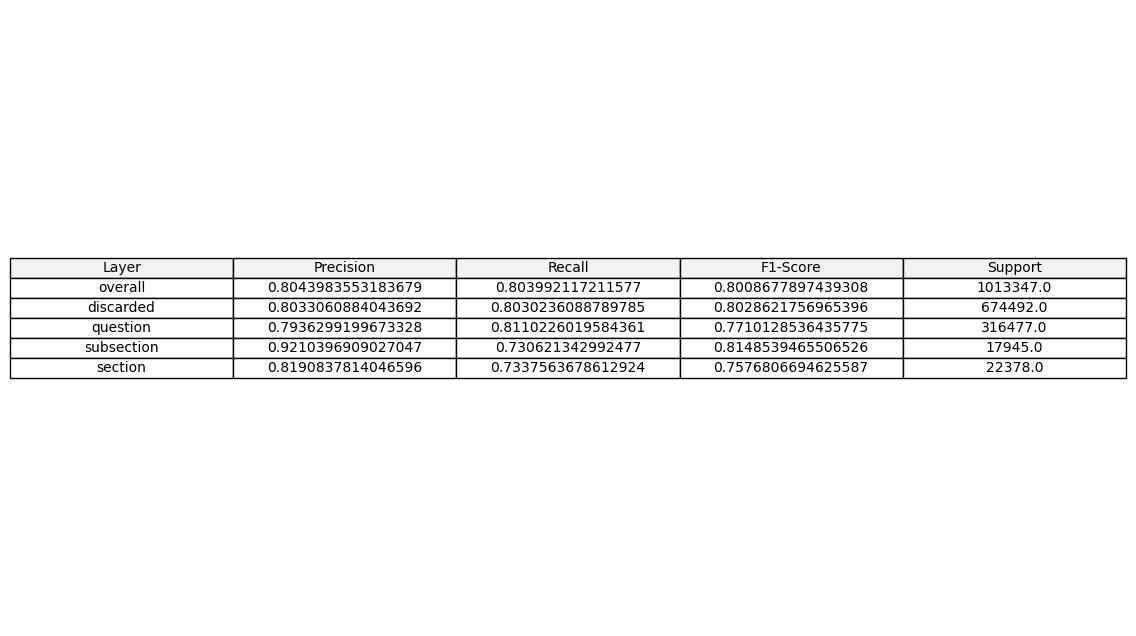

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the required metrics
data = []
for layer, report in classification_reports[3].items():
    if layer == 'section':  # For the third layer, add an extra row for 'subsection'
        subsection_metrics = report['False']
        data.append([
            'subsection',
            subsection_metrics['precision'], subsection_metrics['recall'], subsection_metrics['f1-score'], subsection_metrics['support']
        ])
    weighted_avg_metrics = report['weighted avg']
    data.append([
        layer,
        weighted_avg_metrics['precision'], weighted_avg_metrics['recall'], weighted_avg_metrics['f1-score'], weighted_avg_metrics['support']
    ])

# Create a DataFrame
columns = ['Layer', 'Precision', 'Recall', 'F1-Score', 'Support']
consolidated_report_df = pd.DataFrame(data, columns=columns)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed

# Hide the axis
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=consolidated_report_df.values, 
                 colLabels=consolidated_report_df.columns, 
                 cellLoc='center', 
                 loc='center', 
                 colColours=["#f2f2f2"] * consolidated_report_df.shape[1])

# Adjust the font size and table layout
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Display the plot
plt.show()
